### [LangGraph: human-in-the-loop](https://www.youtube.com/watch?v=9H4gwJGgvfg&list=PLfaIDFEXuae16n2TWUkKq5PgJ0w6Pkwtg&index=4) <img src="https://upload.wikimedia.org/wikipedia/commons/4/42/YouTube_icon_%282013-2017%29.png" alt="YouTube" width="20" height="20">

This is a simplified version of the above:
- no langgraph building code
- human is a node

In [1]:
# Imports and ability to
import os
import sys

# Check if the notebook is running in Google Colab
def in_colab():
    return 'google.colab' in sys.modules

# If in Colab, create the directory structure and download the required files
if in_colab():
    os.makedirs('graph_gen', exist_ok=True)
    !wget -q https://raw.githubusercontent.com/jojohannsen/langgraph_gen/main/graph_gen/common_imports.py -O graph_gen/common_imports.py
    !wget -q https://raw.githubusercontent.com/jojohannsen/langgraph_gen/main/graph_gen/gen_graph.py -O graph_gen/gen_graph.py
    !wget -q https://raw.githubusercontent.com/jojohannsen/langgraph_gen/main/graph_gen/__init__.py -O graph_gen/__init__.py
    %pip install langchain langchain-openai openai langgraph langchain-community langchain-core

# Run common_imports.py
%run graph_gen/common_imports.py

from graph_gen.gen_graph import gen_graph

In [2]:
if in_colab():
    from google.colab import userdata
    userdata.get('TAVILY_API_KEY')
    %env TAVILY_API_KEY=TAVILY_API_KEY
    userdata.get('OPENAI_API_KEY')
    %env OPENAI_API_KEY=OPENAI_API_KEY

In [3]:
# Tools
tools = [TavilySearchResults(max_results=1)]
tool_executor = ToolExecutor(tools)
functions = [convert_to_openai_function(tool) for tool in tools]
model = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
model = model.bind_functions(functions)

# State
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    human_allows_tool: bool

# Nodes:  call_tool and call_model unchanged, adding human node
def last_message(state):
    return state["messages"][-1]
    
def human(state):
    message = last_message(state)
    if 'function_call' in message.additional_kwargs:
        human_input = input(prompt=f"Continue with {message.additional_kwargs['function_call']['name']} (y/n)? ")
        return { "human_allows_tool": human_input == "y" }
    else:
        return {}
        # human_input = input(prompt=f"What would you like to discuss? ")
        # return { "messages": [HumanMessage(content=human_input)] }

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return { "messages": [response] }

def call_tool(state):
    message = last_message(state)
    action = ToolInvocation(
        tool=message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(message.additional_kwargs["function_call"]["arguments"])
    )
    response = tool_executor.invoke(action)
    function_message = FunctionMessage(content=str(response), name=action.tool)
    return { "messages": [function_message] }
    
# Graph and conditions
def human_allows_tool_call(state):
    print(f"human_allows_tool_call: {state['human_allows_tool']}")
    return state["human_allows_tool"]

def ask_human_approval(state):
    message = last_message(state)
    if 'function_call' in message.additional_kwargs:
        human_input = input(prompt=f"Continue with {message.additional_kwargs['function_call']['name']} (y/n)? ")
        return { "human_allows_tool": human_input == "y" }
    else:
        return { "human_allows_tool": False }
        
def should_call_tool(state):
    last_message = state["messages"][-1]
    return "function_call" in last_message.additional_kwargs

def is_done(state):
    last_message = state["messages"][-1]
    return last_message.content == "q" or last_message.content == "quit"

graph_spec = """
   
call_model(AgentState)
    should_call_tool => ask_human_approval
    
ask_human_approval
    human_allows_tool_call => call_tool
    
call_tool
    => call_model

"""

# The graph code
graph_code = gen_graph("human_in_loop", graph_spec)
#print(graph_code)
exec(graph_code)

In [5]:
messages = [HumanMessage(content="tell me about langcloud")]

# this app.stream requires messages, but i really need those to be provided by the graph entry point
# so here I would like to start at the 'human' node, when the human provides input, that is appended to message, then the llm responds.
# the app.stream starts with an existing human message.
for s in human_in_loop.stream({"messages": messages, "human_allows_tool_call": False}, stream_mode="updates"):
    print(s)

print("DONE")

{'call_model': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"LangCloud"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_dd932ca5d1'}, id='run-5b4ecdba-2759-4d51-8510-badee6e3a35b-0')]}}


Continue with tavily_search_results_json (y/n)?  y


human_allows_tool_call: True
{'ask_human_approval': {'human_allows_tool': True}}
{'call_tool': {'messages': [FunctionMessage(content='[{\'url\': \'https://www.yarn.com/products/lang-cloud\', \'content\': "Product Details. Cloud by Lang Yarns is a light and airy bulky weight, blown yarn. The colorful striping gives any garment a wow factor that looks impressive. Cloud comes in a generous 284 yards per 100g meaning you\'ll have fewer ends to weave in at the end of your project! Shop Lang Cloud, perfect for your Knitting projects."}]', name='tavily_search_results_json')]}}
{'call_model': {'messages': [AIMessage(content='It appears that "Lang Cloud" refers to a specific type of yarn produced by Lang Yarns. Here are some details about it:\n\n- **Type**: Light and airy bulky weight, blown yarn.\n- **Features**: Colorful striping that adds a striking visual effect to garments.\n- **Length**: Comes in a generous 284 yards per 100 grams, which means fewer ends to weave in at the end of your pro

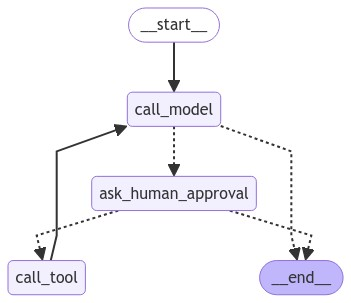

In [6]:
from IPython.display import Image, display

try:
    display(Image(human_in_loop.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass